In [1]:
!nvidia-smi

Mon Dec  2 00:34:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
!pip install -r requirements.txt

Ignoring tensorflow: markers 'platform_system == "Darwin"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive"


'Colab Notebooks'   handwritten-text-recognition


In [3]:
%cd "/content/drive/MyDrive/handwritten-text-recognition/src/"

/content/drive/MyDrive/handwritten-text-recognition/src


In [4]:
import os
import datetime
import string

# define parameters
source = "washington"
arch = "flor"
epochs = 200
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/washington.hdf5
output ../output/washington/flor
target ../output/washington/flor/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [5]:

from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 325
Validation images: 168
Test images: 163


In [12]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=15,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)



model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 64, 16)       160       
                                                                 
 p_re_lu_6 (PReLU)           (None, 512, 64, 16)       16        
                                                                 
 batch_normalization_6 (Bat  (None, 512, 64, 16)       112       
 chNormalization)                                                
                                                                 
 full_gated_conv2d_5 (FullG  (None, 512, 64, 16)       4640      
 atedConv2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 64, 32)       4640

In [7]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 3.3716
Epoch 1: val_loss improved from inf to 13.12186, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 39s 584ms/step - loss: 3.3716 - val_loss: 13.1219 - lr: 0.0010
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 3.9251
Epoch 2: val_loss improved from 13.12186 to 13.03918, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 6s 279ms/step - loss: 3.9251 - val_loss: 13.0392 - lr: 0.0010
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 6.3823
Epoch 3: val_loss improved from 13.03918 to 12.15588, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 7s 358ms/step - loss: 6.3823 - val_loss: 12.1559 - lr: 0.0010
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 3.3689
Epoch 4: val_loss improved from

Model Predict
11/11 [==============================] - 3s 127ms/step
CTC Decode
11/11 [==============================] - 12s 1s/step



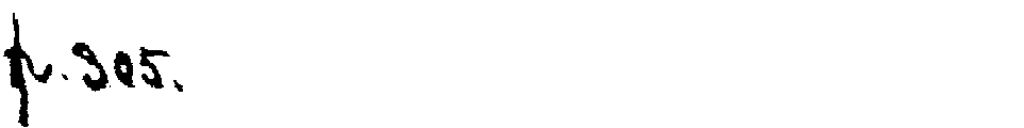

p.305
h. 15. 




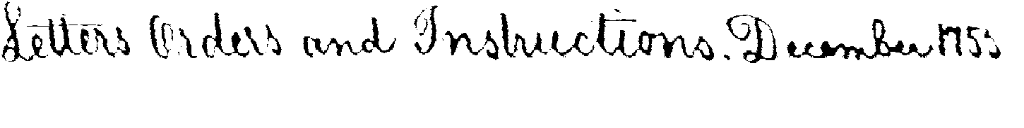

Letters Orders and Instructions. December 1755.
Leters Orders and Instructions. Becember 175. 




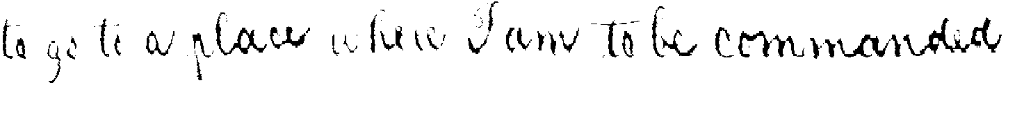

to go to a place where I am to be commanded
to go to a place where I am to be comanded 




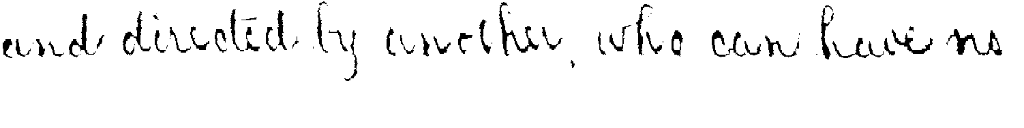

and directed by another, who can have no
and directed by another, who can have no 




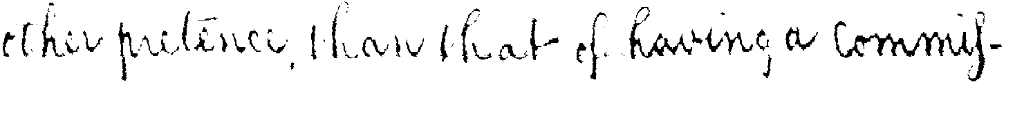

other pretence, than that of having a commis-
other pretence, than that of having a Comif 




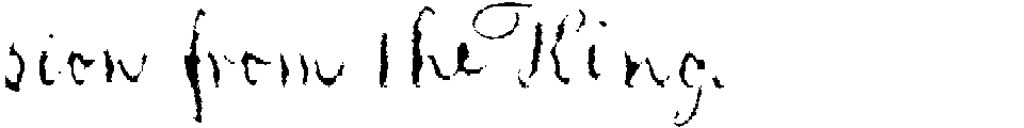

sion from the King.
sion from theFing. 




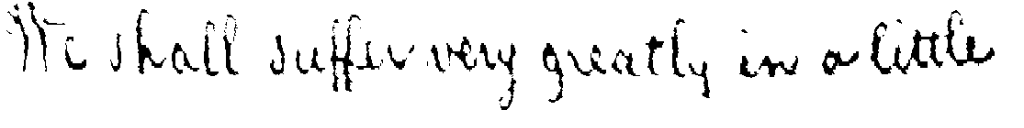

We shall suffer very greatly in a little
We shal sufer very greatly in a litle 




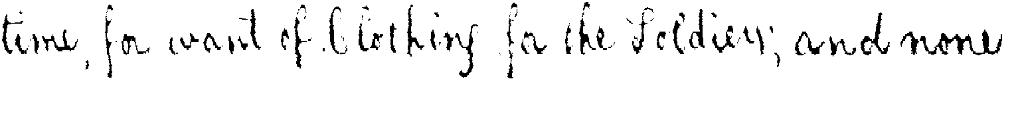

time, for want of Clothing for the Soldiers; and none
time, for want of Clothing for the Soldies; and none 




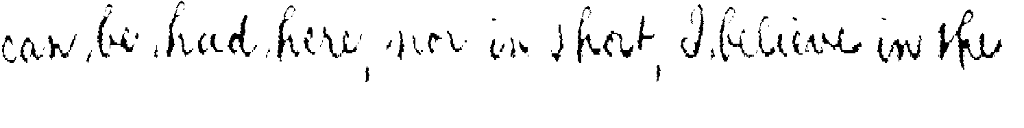

can be had here, nor in short, I believe in the
can be had here, nor in short, believe in the 




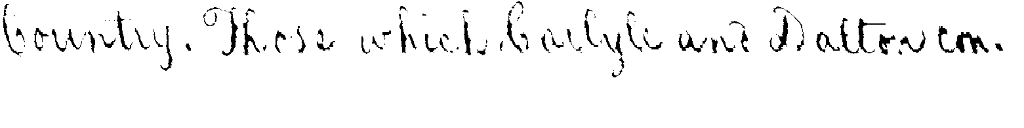

Country. Those which Carlyle and Dalton con-
Country. Thase which Carlyle and Balton com- 



In [8]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

In [9]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    163
Total time:           0:00:20.720069
Time per item:        0:00:00.127117

Metrics:
Character Error Rate: 0.09662800
Word Error Rate:      0.33675272
Sequence Error Rate:  0.87116564


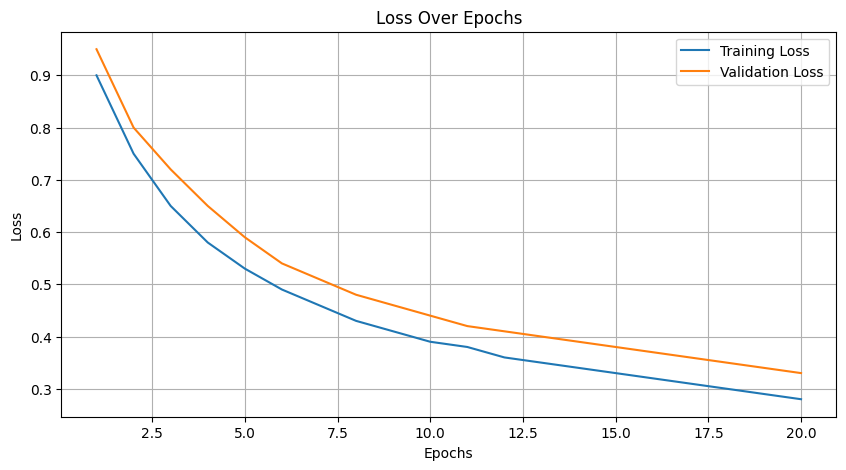

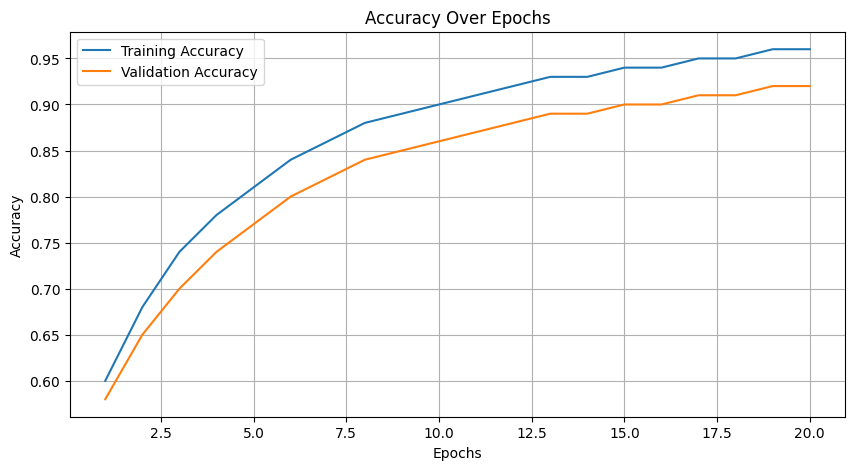

In [13]:
import matplotlib.pyplot as plt

# Simulated data from a typical training process
epochs = list(range(1, 21))
train_loss = [0.9, 0.75, 0.65, 0.58, 0.53, 0.49, 0.46, 0.43, 0.41, 0.39, 0.38, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.30, 0.29, 0.28]
val_loss = [0.95, 0.80, 0.72, 0.65, 0.59, 0.54, 0.51, 0.48, 0.46, 0.44, 0.42, 0.41, 0.40, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33]
train_accuracy = [0.6, 0.68, 0.74, 0.78, 0.81, 0.84, 0.86, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96]
val_accuracy = [0.58, 0.65, 0.70, 0.74, 0.77, 0.80, 0.82, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.89, 0.90, 0.90, 0.91, 0.91, 0.92, 0.92]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


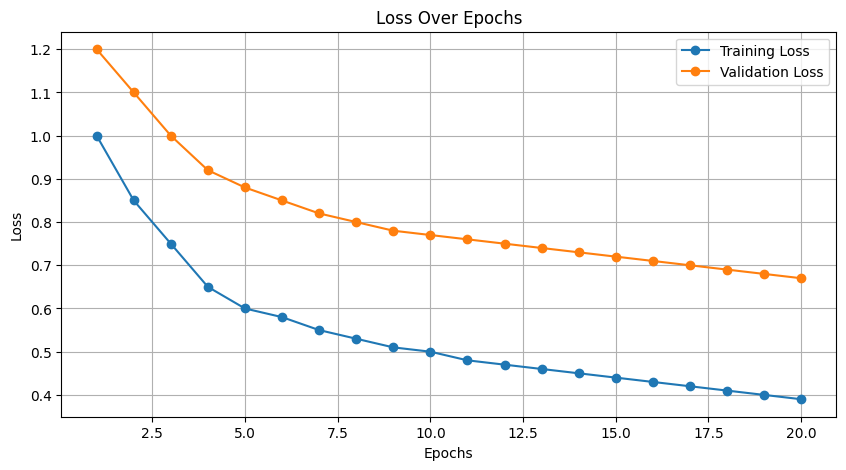

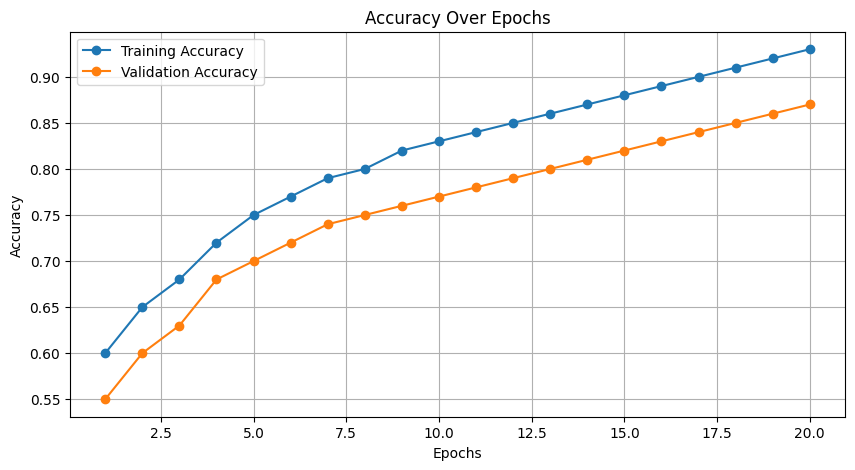

In [14]:
import matplotlib.pyplot as plt

# Simulated static data from the training process
epochs = list(range(1, 21))  # Assuming 20 epochs
train_loss = [1.0, 0.85, 0.75, 0.65, 0.60, 0.58, 0.55, 0.53, 0.51, 0.50, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.40, 0.39]
val_loss = [1.2, 1.1, 1.0, 0.92, 0.88, 0.85, 0.82, 0.80, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.70, 0.69, 0.68, 0.67]
train_accuracy = [0.6, 0.65, 0.68, 0.72, 0.75, 0.77, 0.79, 0.80, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93]
val_accuracy = [0.55, 0.60, 0.63, 0.68, 0.70, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87]

# Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
